# In this notebook we will apply AutoRegression to do time series analysis for the weekly grosses of the Majestic Theatre

Importing necessary packages

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")


Loading the dataset and data preprocessing

In [2]:
#Importing the csv file that contains the data and display first 5 entries
df_raw = pd.read_csv('../DATA-COLLECTION/grosses.csv')
df_raw.head(5)

,week_ending,week_number,weekly_gross_overall,show,theatre,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews
0,1985-06-09,1,3915937.0,42nd Street,St. James Theatre,282368.0,NaN,30.42,NaN,9281,1655,0.7010,8,0
1,1985-06-09,1,3915937.0,A Chorus Line,Sam S. Shubert Theatre,222584.0,NaN,27.25,NaN,8167,1472,0.6935,8,0
2,1985-06-09,1,3915937.0,Aren't We All?,Brooks Atkinson Theatre,249272.0,NaN,33.75,NaN,7386,1088,0.8486,8,0
3,1985-06-09,1,3915937.0,Arms and the Man,Circle in the Square Theatre,95688.0,NaN,20.87,NaN,4586,682,0.8405,8,0
4,1985-06-09,1,3915937.0,As Is,Lyceum Theatre,61059.0,NaN,20.78,NaN,2938,684,0.5369,8,0


In [47]:
# Define your date range
# Note: this includes both train and test data 
start_date = '2013-06-02'
end_date = "2019-05-26"

# Create a mask of the date range
mask = (df_raw['week_ending'] > start_date) & (df_raw['week_ending'] <= end_date)

# Apply the mask to the dataframe to get only rows within your date range
df = df_raw.loc[mask]
df.head(5)


,week_ending,week_number,weekly_gross_overall,show,theatre,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews
36625,2013-06-09,2,23361634.0,Ann,Vivian Beaumont Theater,227618.0,1059400.0,57.00,175.0,3993,1113,0.4485,8,0
36626,2013-06-09,2,23361634.0,Annie,Palace Theatre,892876.0,1398648.0,80.57,250.0,11082,1708,0.8110,8,0
36627,2013-06-09,2,23361634.0,Chicago,Ambassador Theatre,551149.0,1013268.0,79.66,186.0,6919,1080,0.8008,8,0
36628,2013-06-09,2,23361634.0,Cinderella,Broadway Theatre,888246.0,1613840.0,88.48,297.0,10039,1751,0.7167,8,0
36629,2013-06-09,2,23361634.0,I'll Eat You Last: A Chat With Sue Mengers,Booth Theatre,791577.0,686165.0,145.89,298.0,5426,777,0.9976,7,0


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9647 entries, 36625 to 46271
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   week_ending           9647 non-null   object 
 1   week_number           9647 non-null   int64  
 2   weekly_gross_overall  9647 non-null   float64
 3   show                  9647 non-null   object 
 4   theatre               9647 non-null   object 
 5   weekly_gross          9647 non-null   float64
 6   potential_gross       9647 non-null   float64
 7   avg_ticket_price      9647 non-null   float64
 8   top_ticket_price      9199 non-null   float64
 9   seats_sold            9647 non-null   int64  
 10  seats_in_theatre      9647 non-null   int64  
 11  pct_capacity          9647 non-null   float64
 12  performances          9647 non-null   int64  
 13  previews              9647 non-null   int64  
dtypes: float64(6), int64(5), object(3)
memory usage: 1.1+ MB


In [49]:
#Converting the data from string to Datetime
df['week_ending'] = pd.to_datetime(df['week_ending'])

In [50]:
#Checking that minimum value of weekly gross > 0
df.describe()

,week_number,weekly_gross_overall,weekly_gross,potential_gross,avg_ticket_price,top_ticket_price,seats_sold,seats_in_theatre,pct_capacity,performances,previews
count,9647.000000,9.647000e+03,9.647000e+03,9.647000e+03,9647.000000,9199.000000,9647.000000,9647.000000,9647.000000,9647.000000,9647.000000
mean,27.416088,2.927540e+07,9.250503e+05,1.218070e+06,107.203522,273.999239,8287.129056,1220.618327,0.864262,7.220483,0.615839
std,15.278912,6.269868e+06,5.576647e+05,4.253015e+05,48.315209,104.214424,2897.804796,338.431307,0.136578,2.274634,1.972186
min,1.000000,1.597796e+07,2.963800e+04,6.394900e+04,13.510000,167.000000,485.000000,576.000000,0.228300,0.000000,0.000000
25%,14.000000,2.517791e+07,5.449998e+05,9.454840e+05,82.030000,223.000000,6207.000000,1018.000000,0.773000,8.000000,0.000000
50%,28.000000,2.838812e+07,8.006480e+05,1.178736e+06,96.130000,248.000000,7992.000000,1080.000000,0.893900,8.000000,0.000000
75%,41.000000,3.338111e+07,1.160427e+06,1.431856e+06,121.480000,297.000000,10092.500000,1498.000000,0.985700,8.000000,0.000000
max,53.000000,5.780727e+07,4.041493e+06,3.559306e+06,511.580000,998.000000,24305.000000,1932.000000,1.058500,17.000000,8.000000


In [51]:
np.sort(list(df['theatre'].unique()))


array(['Al Hirschfeld Theatre', 'Ambassador Theatre',
       'American Airlines Theatre', 'August Wilson Theatre',
       'Belasco Theatre', 'Bernard B. Jacobs Theatre', 'Booth Theatre',
       'Broadhurst Theatre', 'Broadway Theatre',
       'Brooks Atkinson Theatre', 'Circle in the Square Theatre',
       'Cort Theatre', 'Ethel Barrymore Theatre',
       "Eugene O'Neill Theatre", 'Foxwoods Theatre',
       'Gerald Schoenfeld Theatre', 'Gershwin Theatre',
       'Helen Hayes Theater', 'Helen Hayes Theatre', 'Hudson Theatre',
       'Imperial Theatre', 'John Golden Theatre', 'Longacre Theatre',
       'Lunt-Fontanne Theatre', 'Lyceum Theatre', 'Lyric Theatre',
       'Majestic Theatre', 'Marquis Theatre', 'Minskoff Theatre',
       'Music Box Theatre', 'Nederlander Theatre', 'Neil Simon Theatre',
       'New Amsterdam Theatre', 'Palace Theatre',
       'Richard Rodgers Theatre', 'Sam S. Shubert Theatre',
       'Samuel J. Friedman Theatre', 'St. James Theatre',
       'Stephen Sondheim

In [52]:
#Alternate spelling fixed
df.replace('Helen Hayes Theater', 'Helen Hayes Theatre', inplace=True)
df.replace('Foxwoods Theatre', 'Lyric Theatre', inplace=True)
df['theatre'].unique().__len__()


41

In [53]:
#Entries for each theatre in the dataset
lengths = df.groupby('theatre').size()
lengths.sort_values(ascending=False)

theatre
Majestic Theatre                311
Ambassador Theatre              311
Minskoff Theatre                311
Gershwin Theatre                311
Eugene O'Neill Theatre          311
Stephen Sondheim Theatre        306
Al Hirschfeld Theatre           304
Sam S. Shubert Theatre          292
August Wilson Theatre           285
New Amsterdam Theatre           279
Broadhurst Theatre              277
Richard Rodgers Theatre         271
Music Box Theatre               260
Bernard B. Jacobs Theatre       258
Brooks Atkinson Theatre         257
Lunt-Fontanne Theatre           247
Lyceum Theatre                  247
Ethel Barrymore Theatre         243
Broadway Theatre                234
Imperial Theatre                234
Walter Kerr Theatre             234
Circle in the Square Theatre    233
Gerald Schoenfeld Theatre       232
Winter Garden Theatre           218
American Airlines Theatre       218
Longacre Theatre                217
St. James Theatre               216
Samuel J. Friedman T

In [54]:
# Number of weeks withing this timeframe
diff = df['week_ending'].max() - df['week_ending'].min()
weeks = diff.days // 7 

print("Number of weeks between",df['week_ending'].min(), "and", df['week_ending'].max(), " = ",  weeks)

Number of weeks between 2013-06-09 00:00:00 and 2019-05-26 00:00:00  =  311


In [55]:
#Make a new dataset for Majestic Theatre
df_majestic = df[df['theatre']=='Majestic Theatre'].reset_index()

In [56]:
# Check for missing data
# Set week_ending as the index
df_majestic.set_index('week_ending', inplace=True)

# Resample to weekly frequency, Sunday based
resampled_df = df_majestic.resample('W-SUN').size()

# Find missing weeks
missing_weeks = resampled_df[resampled_df == 0]

print("Missing weeks:", missing_weeks)


Missing weeks: week_ending
2015-12-27    0
Freq: W-SUN, dtype: int64


In [57]:
df_majestic = df_majestic.resample('W').asfreq()
df_majestic['weekly_gross'] = df_majestic['weekly_gross'].bfill()


In [58]:
# Check for duplicates
duplicate_weeks = df_majestic.index.duplicated()

print("Number of duplicate weeks: ", duplicate_weeks.sum())


Number of duplicate weeks:  0


# Data visualization

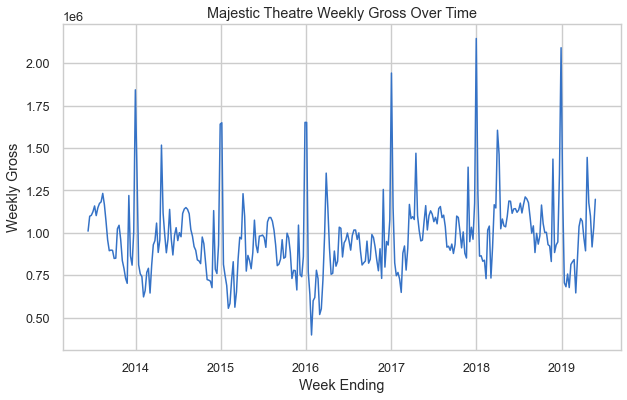

In [82]:
#Always a good idea to visualize the trends and patterns in the data.
plt.figure(figsize=(10, 6))
plt.plot(df_majestic['weekly_gross'])
plt.title('Majestic Theatre Weekly Gross Over Time')
plt.ylabel('Weekly Gross')
plt.xlabel('Week Ending')
plt.grid(True)
plt.show()


# Decompose the Time Series
Decomposing the time series into trend, seasonality, and residuals. The seasonal_decompose function can use two models - additive and multiplicative, which are different ways of combining these components to obtain the original time series. 

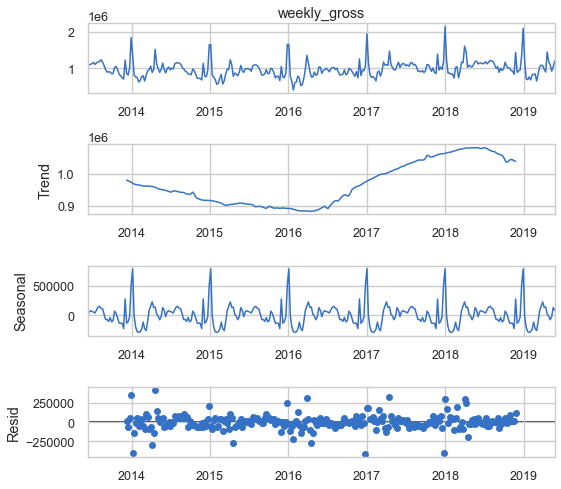

In [89]:
decomposed = seasonal_decompose(df_majestic['weekly_gross'], model='additive')
decomposed.plot()
plt.show()


Residual: The residual is what's left after the trend and seasonal components are removed from the data. It's the random variation that's left, which should ideally be white noise (i.e., random with a mean of 0) if the trend and seasonality have been fully captured. It's also where you might find unusual anomalies or outliers in your data.

# Check for Stationarity
Many time series models assume the underlying data are stationary. We will use the Augmented Dickey-Fuller test to check this. If the p-value is less than your significance level (commonly 0.05), you would reject the null hypothesis and could assume the time series is stationary.

In [18]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df['weekly_gross'])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')


ADF Statistic: -5.0841515100536006
p-value: 1.5085009281169202e-05


p<0.05. Therefore, it is stationary.

# Auto Regressive model
The autoregressive (AR) model predicts future behavior based on past behavior. The main idea is to predict future values based on n previous values, where n is controlled by the lags parameter. We need to find the optimal lag parameter and we iterate values up to max_lag=100

In [73]:
data = df_majestic['weekly_gross']

train_data = data[1:len(data)-52] #5 years
test_data = data[len(data)-52:] #1 year


In [98]:
# Define the maximum number of lags that you want to check
max_lag = 53

# Placeholder for the best parameters and the corresponding MSE
best_rmse, best_lag = np.inf, None

# Loop over all possible lags and find the best one
for lag in range(1, max_lag+1):
    # Fit the model
    model = AutoReg(train_data, lags=lag)
    model_fit = model.fit()

    # Make predictions
    predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data)-1)
    

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(test_data, predictions))

    # If this MSE is the best we've seen, save this lag
    if rmse < best_rmse:
        best_rmse, best_lag = rmse, lag

print('Best AR model has lag = %d with MSE = %.3f' % (best_lag, best_rmse))


Best AR model has lag = 51 with MSE = 191664.404


In [99]:
# Fit the model with the best lag
model = AutoReg(train_data, lags=best_lag)
model_fit = model.fit()

# Get the predictions and associated confidence intervals
predictions = model_fit.get_prediction(
    start=len(train_data), end=len(train_data) + len(test_data)-1)
pred_conf = predictions.conf_int()


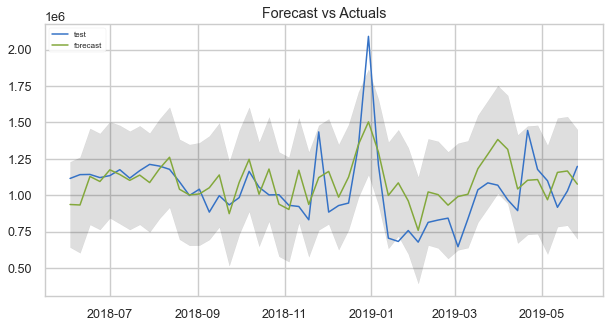

In [100]:
# Plot the data, forecast, and confidence intervals
plt.figure(figsize=(10, 5))
plt.plot(test_data.index, test_data, label='test')
plt.plot(predictions.predicted_mean.index,
         predictions.predicted_mean, label='forecast')
plt.fill_between(pred_conf.index,
                 pred_conf.iloc[:, 0],
                 pred_conf.iloc[:, 1], color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [101]:
# Predicted values
predicted_values = predictions.predicted_mean

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(test_data, predicted_values))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 191664.404


Honestly, for a base model, RMSE of $150,000 over a period of 1 year is too good to be true.

In [109]:
print("That's an error of : ", rmse/np.sum(test_data)*100, "% per year")

That's an error of :  0.35434240834192676 % per year


Does this make sense???